In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob
from scipy import signal
from detect_peaks import detect_peaks

### Set file directory and load ECG data

In [2]:
dir = '/Users/kevin/Documents/CMRG/CAI/ekgstodigitize/xpsFiles/'
files = glob.glob(dir+'*.npz')
file = files[2]
print file

f = np.load(file)
ecg_short = f['ecg_short']
ecg_long = f['ecg_long']

/Users/kevin/Documents/CMRG/CAI/ekgstodigitize/xpsFiles/BiV4.npz


### View V1, II, and V5  with peak detection

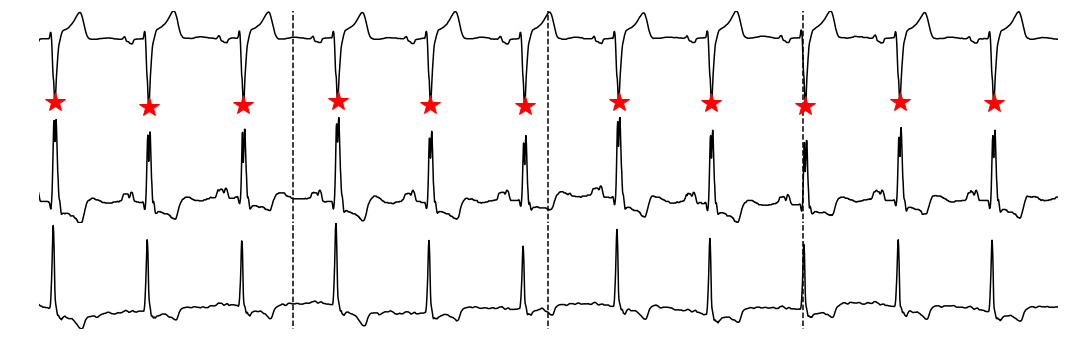

In [3]:
#PLOTTING, PEAK FINDING, and OTHER CODE
ref_lead = 0 # 0 = V1, 1 = II, 2 = V5
max_rate = 200 #bpm - use for peak detect
t_len = ecg_short[1,0]
mpd_pts = int((1./max_rate)*60*1000/t_len)
indexes = detect_peaks(ecg_long[:,ref_lead*2+1], mph = 0.5, mpd=mpd_pts, valley=True)

plt.subplots(6, 1,figsize = (15,5))
plt.subplot(3,1,1)
plt.plot(ecg_long[:,0],ecg_long[:,1],'k')
plt.plot([ecg_short[0,6],ecg_short[0,6]],[5,-5],'k--')
plt.plot([ecg_short[0,12],ecg_short[0,12]],[5,-5],'k--')
plt.plot([ecg_short[0,18],ecg_short[0,18]],[5,-5],'k--')
if ref_lead == 0:
    plt.plot(ecg_long[indexes,0],ecg_long[indexes,1],'r*',markersize = 20)
plt.xlim([0,10000])
plt.ylim([min(ecg_long[:,1])-0.2,max(ecg_long[:,1])])
plt.axis('off')

plt.subplot(3,1,2)
plt.plot(ecg_long[:,2],ecg_long[:,3],'k')
plt.plot([ecg_short[0,6],ecg_short[0,6]],[5,-5],'k--')
plt.plot([ecg_short[0,12],ecg_short[0,12]],[5,-5],'k--')
plt.plot([ecg_short[0,18],ecg_short[0,18]],[5,-5],'k--')
plt.xlim([0,10000])
plt.ylim([min(ecg_long[:,3]),max(ecg_long[:,3])])
plt.axis('off')

plt.subplot(3,1,3)
plt.plot(ecg_long[:,4],ecg_long[:,5],'k')
plt.plot([ecg_short[0,6],ecg_short[0,6]],[5,-5],'k--')
plt.plot([ecg_short[0,12],ecg_short[0,12]],[5,-5],'k--')
plt.plot([ecg_short[0,18],ecg_short[0,18]],[5,-5],'k--')
plt.xlim([0,10000])
plt.ylim([min(ecg_long[:,5]),max(ecg_long[:,5])])
plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

### Selected three beats for VCG calculation

In [4]:
#Index beats from 1
beat_1 = 2
beat_2 = 7
beat_3 = 11

### Define QRS width and view leads V1, II, and V5 for selected beats

QRS duration ~  378.48


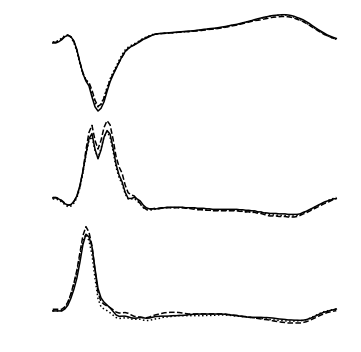

In [5]:
#PLOT SELECTED BEATS AND TRIM W/ QRS PARAMS
#*************************#
pre_QRS = 15 #20 pts = ~80 ms
post_QRS = 80
print 'QRS duration ~ ', (pre_QRS+post_QRS)*t_len

QRS_only = False
frame_w = 100

avg_V_ends = True
#*************************#

#Preprocess ECG clips
#Find peak index in short clips
beat_1_offset = 0
beat_2_offset = np.where(ecg_long[:,0] == ecg_short[0,12])[0][0]
beat_3_offset = np.where(ecg_long[:,0] == ecg_short[0,18])[0][0]
indexes_short = [indexes[beat_1-1],indexes[beat_2-1]-beat_2_offset,indexes[beat_3-1]-beat_3_offset]
#[t V1_b1 V1_b2 V1_b3 V2 V3 V4 V5_b1 V5_b2 V5_b3 V6 I II_b1 II_b2 II_b3]
ecg = np.zeros((pre_QRS+post_QRS,15))
ecg[:,0] = np.arange(0,(pre_QRS+post_QRS))*t_len #t

#Need to add nan padding and error catching
ecg[:,1] = ecg_long[indexes[beat_1-1]-pre_QRS:indexes[beat_1-1]+post_QRS,1]  #V1_b1
ecg[:,2] = ecg_long[indexes[beat_2-1]-pre_QRS:indexes[beat_2-1]+post_QRS,1]  #V1_b2
ecg[:,3] = ecg_long[indexes[beat_3-1]-pre_QRS:indexes[beat_3-1]+post_QRS,1]  #V1_b3

ecg[:,4] = ecg_short[indexes_short[1]-pre_QRS:indexes_short[1]+post_QRS,15]  #V2
ecg[:,5] = ecg_short[indexes_short[1]-pre_QRS:indexes_short[1]+post_QRS,17]  #V3
ecg[:,6] = ecg_short[indexes_short[2]-pre_QRS:indexes_short[2]+post_QRS,19]  #V4

ecg[:,7] = ecg_long[indexes[beat_1-1]-pre_QRS:indexes[beat_1-1]+post_QRS,5]  #V5_b1
ecg[:,8] = ecg_long[indexes[beat_2-1]-pre_QRS:indexes[beat_2-1]+post_QRS,5]  #V5_b2
ecg[:,9] = ecg_long[indexes[beat_3-1]-pre_QRS:indexes[beat_3-1]+post_QRS,5]  #V5_b3

ecg[:,10] = ecg_short[indexes_short[2]-pre_QRS:indexes_short[2]+post_QRS,23]  #V6
ecg[:,11] = ecg_short[indexes_short[0]-pre_QRS:indexes_short[0]+post_QRS,1]  #I

ecg[:,12] = ecg_long[indexes[beat_1-1]-pre_QRS:indexes[beat_1-1]+post_QRS,3]  #II_b1
ecg[:,13] = ecg_long[indexes[beat_2-1]-pre_QRS:indexes[beat_2-1]+post_QRS,3]  #II_b2
ecg[:,14] = ecg_long[indexes[beat_3-1]-pre_QRS:indexes[beat_3-1]+post_QRS,3]  #II_b3

#Avg first and last voltage val for zero
if avg_V_ends:
    for i in range(1,15):
        offset = np.mean([ecg[0,i],ecg[-1,i]])
        ecg[:,i] = ecg[:,i] - offset
               
plt.subplots(3, 1,figsize = (5,5))
#V1
plt.subplot(3,1,1)
plt.plot(ecg[:,0],ecg[:,1],'k')
plt.plot(ecg[:,0],ecg[:,2],'k--')
plt.plot(ecg[:,0],ecg[:,3],'k:')
plt.axis('off')

#II
plt.subplot(3,1,2)
plt.plot(ecg[:,0],ecg[:,12],'k')
plt.plot(ecg[:,0],ecg[:,13],'k--')
plt.plot(ecg[:,0],ecg[:,14],'k:')
plt.axis('off')

#V5
plt.subplot(3,1,3)
plt.plot(ecg[:,0],ecg[:,7],'k')
plt.plot(ecg[:,0],ecg[:,8],'k--')
plt.plot(ecg[:,0],ecg[:,9],'k:')
plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

### CALCULATE VCG

In [6]:
#KORS AND DOWER CALCULATIONS

#ecg8 = [V1 V2 V3 V4 V5 V6 I II]

ecg8 = np.array([ecg[:,1],ecg[:,4],ecg[:,5],ecg[:,6],ecg[:,7],ecg[:,10],ecg[:,11],ecg[:,12]])

kors = np.array([-0.13,0.05,-0.01,0.14,0.06,0.54,0.38,-0.07,
                 0.06,-0.02,-0.05,0.06,-0.17,0.13,-0.07,0.93,
                 -0.43,-0.06,-0.14,-0.20,-0.11,0.31,0.11,-0.23]).reshape(3,8)

dinv = np.array([-0.172,-0.074,0.122,0.231,0.239,0.194,0.156,-0.010,
        0.057,-0.019,-0.106,-0.022,0.041,0.048,-0.227,0.887,
       -0.229,-0.310,-0.246,-0.063,0.055,0.108,0.022,0.102]).reshape(3,8)

kVCG = np.dot(kors,ecg8).transpose();
dVCG = np.dot(dinv,ecg8).transpose();

### Plot VCG

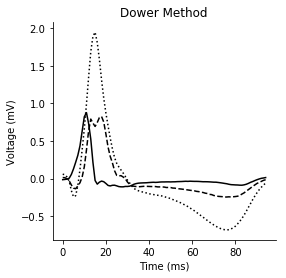

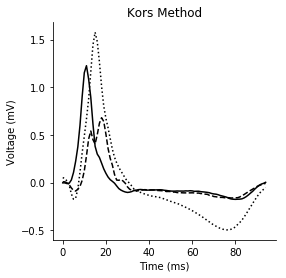

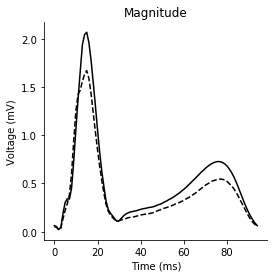

In [7]:
t = range(0,len(dVCG))
plt.figure(figsize=(4,4))
plt.plot(t,dVCG[:,0],'k-',t,dVCG[:,1],'k--',t,dVCG[:,2],'k:')
plt.title("Dower Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

plt.figure(figsize=(4,4))
plt.plot(t,kVCG[:,0],'k-',t,kVCG[:,1],'k--',t,kVCG[:,2],'k:')
plt.title("Kors Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

plt.figure(figsize=(4,4))
plt.plot(t,np.linalg.norm(dVCG,axis=1),'k-',t,np.linalg.norm(kVCG,axis=1),'k--')
plt.title("Magnitude")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()


### LOAD PREVIOUS VCG DATA

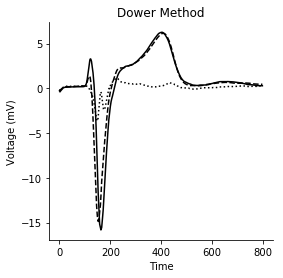

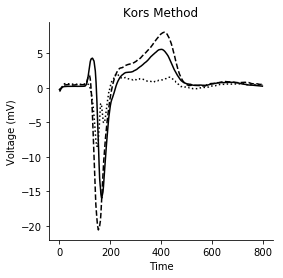

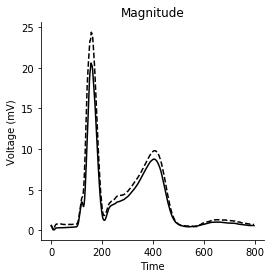

In [8]:
vcg_dir = '/Users/kevin/Documents/CMRG/CAI/ekgstodigitize/VCGs/'
BiV = file.split('/')[-1].strip('.npz')
dvcg_file = glob.glob(vcg_dir + BiV+'*dVCG*.txt')[0]
kvcg_file = glob.glob(vcg_dir + BiV+'*kVCG*.txt')[0]
dVCG_chris = np.genfromtxt(dvcg_file)
kVCG_chris = np.loadtxt(kvcg_file)
t_chris = range(0,len(dVCG_chris))

plt.figure(figsize=(4,4))
plt.plot(t_chris,dVCG_chris[:,0],'k-',t_chris,dVCG_chris[:,1],'k--',t_chris,dVCG_chris[:,2],'k:')
plt.title("Dower Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

plt.figure(figsize=(4,4))
plt.plot(t_chris,kVCG_chris[:,0],'k-',t_chris,kVCG_chris[:,1],'k--',t_chris,kVCG_chris[:,2],'k:')
plt.title("Kors Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

plt.figure(figsize=(4,4))
plt.plot(t_chris,np.linalg.norm(dVCG_chris,axis=1),'k-',t_chris,np.linalg.norm(kVCG_chris,axis=1),'k--')
plt.title("Magnitude")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()


### COMPARE PREVIOUS DATA TO NEW RESULTS

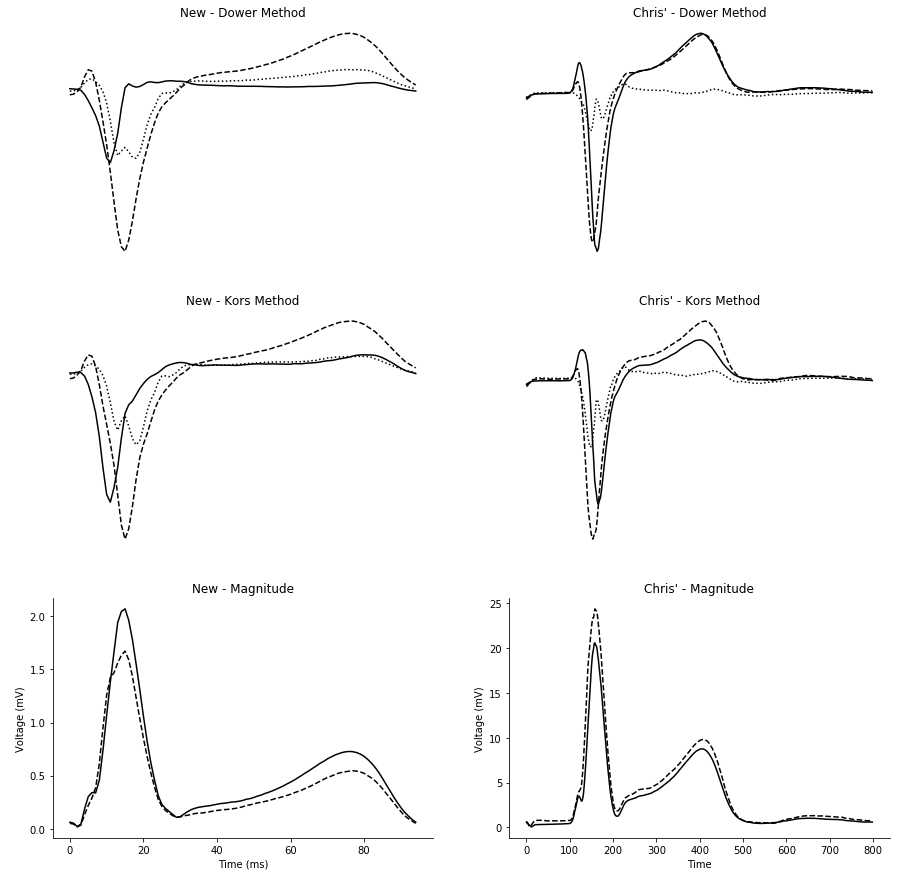

In [9]:
#PLOT COMPARE
plt.subplots(3, 2,figsize = (15,15))
plt.subplot(3,2,1)
plt.plot(t,dVCG[:,0]*-1,'k-',t,dVCG[:,2]*-1,'k--',t,dVCG[:,1]*-1,'k:')
plt.title("New - Dower Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
plt.axis('off')

plt.subplot(3,2,3)
plt.plot(t,kVCG[:,0]*-1,'k-',t,kVCG[:,2]*-1,'k--',t,kVCG[:,1]*-1,'k:')
plt.title("New - Kors Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
plt.axis('off')

plt.subplot(3,2,5)
plt.plot(t,np.linalg.norm(dVCG,axis=1),'k-',t,np.linalg.norm(kVCG,axis=1),'k--')
plt.title("New - Magnitude")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time (ms)")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.subplot(3,2,2)
plt.plot(t_chris,dVCG_chris[:,0],'k-',t_chris,dVCG_chris[:,1],'k--',t_chris,dVCG_chris[:,2],'k:')
plt.title("Chris' - Dower Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
plt.axis('off')

plt.subplot(3,2,4)
plt.plot(t_chris,kVCG_chris[:,0],'k-',t_chris,kVCG_chris[:,1],'k--',t_chris,kVCG_chris[:,2],'k:')
plt.title("Chris' - Kors Method")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
plt.axis('off')

plt.subplot(3,2,6)
plt.plot(t_chris,np.linalg.norm(dVCG_chris,axis=1),'k-',t_chris,np.linalg.norm(kVCG_chris,axis=1),'k--')
plt.title("Chris' - Magnitude")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()


### 3d VCG plots

<IPython.core.display.Javascript object>


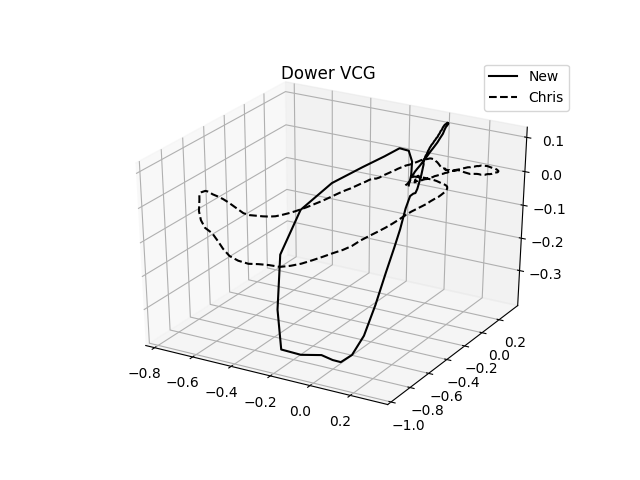

<IPython.core.display.Javascript object>


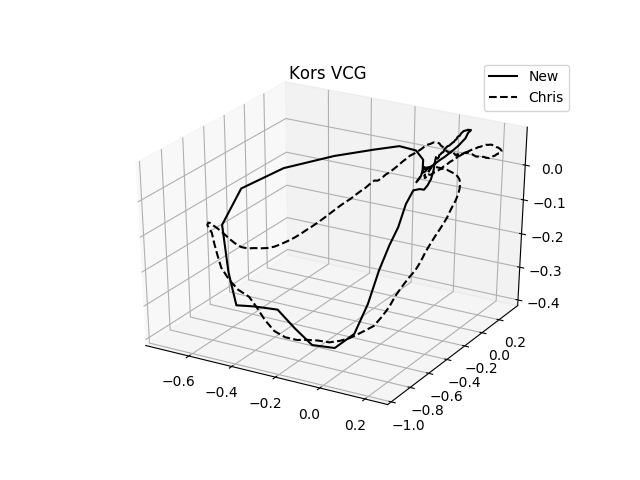

In [10]:
%matplotlib notebook
#Normalize
norm_dVCG_chris = dVCG_chris/max(np.linalg.norm(dVCG_chris,axis=1))
norm_dVCG = dVCG/max(np.linalg.norm(dVCG,axis=1))

norm_kVCG_chris = kVCG_chris/max(np.linalg.norm(kVCG_chris,axis=1))
norm_kVCG = kVCG/max(np.linalg.norm(kVCG,axis=1))

plt.figure()
plt.gca(projection='3d')
plt.plot(norm_dVCG[:,0]*-1,norm_dVCG[:,2]*-1,norm_dVCG[:,1]*-1,'k-', label = 'New')
plt.plot(norm_dVCG_chris[:,0],norm_dVCG_chris[:,1],norm_dVCG_chris[:,2],'k--', label = 'Chris')
plt.title("Dower VCG")
plt.legend()
plt.show()

plt.figure()
plt.gca(projection='3d')
plt.plot(norm_kVCG[:,0]*-1,norm_kVCG[:,2]*-1,norm_kVCG[:,1]*-1,'k-', label = 'New')
plt.plot(norm_kVCG_chris[:,0],norm_kVCG_chris[:,1],norm_kVCG_chris[:,2],'k--', label = 'Chris')
plt.title("Kors VCG")
plt.legend()
plt.show()